## Report on Churn Problem

### 1. Preparing Customer Data for Training.

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,LabelEncoder
import shap


In [2]:
customer_data = pd.read_csv('ml_case_training_data.csv')
customer_data.head()

,id,activity_new,campaign_disc_ele,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_first_activ,...,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max
0,48ada52261e7cf58715202705a0451c9,esoiiifxdlbkcsluxmfuacbdckommixw,NaN,lmkebamcaaclubfxadlmueccxoimlema,309275,0,10025,07-11-2012,06-11-2016,NaN,...,58.995952,f,831.8,-41.76,-41.76,1,1732.36,3,ldkssxwpmemidmecebumciepifcamkci,180.000
1,24011ae4ebbe3035111d65fa7c15bc57,NaN,NaN,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,15-06-2013,15-06-2016,NaN,...,40.606701,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648
2,d29c2c54acc38ff3c0614d0a653813dd,NaN,NaN,NaN,4660,0,0,21-08-2009,30-08-2016,NaN,...,44.311378,f,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800
3,764c75f661154dac3a6c254cd082ea7d,NaN,NaN,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,16-04-2010,16-04-2016,NaN,...,44.311378,f,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856
4,bba03439a292a1e166f80264c16191cb,NaN,NaN,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,30-03-2010,30-03-2016,NaN,...,44.311378,f,0.0,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200


Percentage of null entries in each column of the data:

In [3]:
customer_data.isna().sum() / customer_data.shape[0] * 100

id                            0.000000
activity_new                 59.300447
campaign_disc_ele           100.000000
channel_sales                26.205268
cons_12m                      0.000000
cons_gas_12m                  0.000000
cons_last_month               0.000000
date_activ                    0.000000
date_end                      0.012425
date_first_activ             78.205765
date_modif_prod               0.975398
date_renewal                  0.248509
forecast_base_bill_ele       78.205765
forecast_base_bill_year      78.205765
forecast_bill_12m            78.205765
forecast_cons                78.205765
forecast_cons_12m             0.000000
forecast_cons_year            0.000000
forecast_discount_energy      0.782803
forecast_meter_rent_12m       0.000000
forecast_price_energy_p1      0.782803
forecast_price_energy_p2      0.782803
forecast_price_pow_p1         0.782803
has_gas                       0.000000
imp_cons                      0.000000
margin_gross_pow_ele     

Inference: We can drop columns having more than 50% missing values.

In [4]:
drop_columns = []
for i in customer_data.columns:
    if((customer_data[i].isna().sum() / customer_data.shape[0] * 100) > 50):
        drop_columns.append(i)

In [5]:
drop_columns

['activity_new',
 'campaign_disc_ele',
 'date_first_activ',
 'forecast_base_bill_ele',
 'forecast_base_bill_year',
 'forecast_bill_12m',
 'forecast_cons']

In [6]:
customer_data.drop(drop_columns,axis = 1,inplace = True)

In [7]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16096 entries, 0 to 16095
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        16096 non-null  object 
 1   channel_sales             11878 non-null  object 
 2   cons_12m                  16096 non-null  int64  
 3   cons_gas_12m              16096 non-null  int64  
 4   cons_last_month           16096 non-null  int64  
 5   date_activ                16096 non-null  object 
 6   date_end                  16094 non-null  object 
 7   date_modif_prod           15939 non-null  object 
 8   date_renewal              16056 non-null  object 
 9   forecast_cons_12m         16096 non-null  float64
 10  forecast_cons_year        16096 non-null  int64  
 11  forecast_discount_energy  15970 non-null  float64
 12  forecast_meter_rent_12m   16096 non-null  float64
 13  forecast_price_energy_p1  15970 non-null  float64
 14  foreca

We can drop 'channel_sales' and 'id' columns too as they are not much of use.

In [8]:
customer_data.drop(['channel_sales','id'],axis = 1, inplace = True)

### We will fill the missing values in the remaining columns. In continous columns, we will use 'mean' value and in categorical columns we will use 'mode' values.

In [9]:
cont_features = []
for i in customer_data.columns:
    if((customer_data[i].dtype) == 'int64' or (customer_data[i].dtype) == 'float64'):
        cont_features.append(i)

cont_features

['cons_12m',
 'cons_gas_12m',
 'cons_last_month',
 'forecast_cons_12m',
 'forecast_cons_year',
 'forecast_discount_energy',
 'forecast_meter_rent_12m',
 'forecast_price_energy_p1',
 'forecast_price_energy_p2',
 'forecast_price_pow_p1',
 'imp_cons',
 'margin_gross_pow_ele',
 'margin_net_pow_ele',
 'nb_prod_act',
 'net_margin',
 'num_years_antig',
 'pow_max']

In [10]:
imptr = SimpleImputer(missing_values = np.nan,strategy="mean")
for cols in cont_features:
    customer_data[cols] = imptr.fit_transform(customer_data[cols].values.reshape(-1,1))

In [38]:
cat_features = []
for i in customer_data.columns:
    if(customer_data[i].dtype == 'object'):
        cat_features.append(i)

cat_features

['date_activ',
 'date_end',
 'date_modif_prod',
 'date_renewal',
 'has_gas',
 'origin_up']

In [12]:
imptr = SimpleImputer(missing_values = np.nan,strategy="most_frequent")
for cols in cat_features:
    customer_data[cols] = imptr.fit_transform(customer_data[cols].values.reshape(-1,1))

In [13]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16096 entries, 0 to 16095
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   cons_12m                  16096 non-null  float64
 1   cons_gas_12m              16096 non-null  float64
 2   cons_last_month           16096 non-null  float64
 3   date_activ                16096 non-null  object 
 4   date_end                  16096 non-null  object 
 5   date_modif_prod           16096 non-null  object 
 6   date_renewal              16096 non-null  object 
 7   forecast_cons_12m         16096 non-null  float64
 8   forecast_cons_year        16096 non-null  float64
 9   forecast_discount_energy  16096 non-null  float64
 10  forecast_meter_rent_12m   16096 non-null  float64
 11  forecast_price_energy_p1  16096 non-null  float64
 12  forecast_price_energy_p2  16096 non-null  float64
 13  forecast_price_pow_p1     16096 non-null  float64
 14  has_ga

In [14]:
customer_data.describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max
count,1.609600e+04,1.609600e+04,1.609600e+04,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000
mean,1.948044e+05,3.191164e+04,1.946154e+04,2370.555949,1907.347229,0.991547,70.309945,0.135901,0.052951,43.533496,196.123447,22.462276,21.460318,1.347788,217.987028,5.030629,20.604131
std,6.795151e+05,1.775885e+05,8.235676e+04,4035.085664,5257.364759,5.140728,79.023251,0.026149,0.048427,5.191810,494.366979,23.691309,27.906072,1.459808,366.571095,1.676101,21.770392
min,-1.252760e+05,-3.037000e+03,-9.138600e+04,-16689.260000,-85627.000000,0.000000,-242.960000,0.000000,0.000000,-0.122184,-9038.210000,-525.540000,-615.660000,1.000000,-4148.990000,1.000000,1.000000
25%,5.906250e+03,0.000000e+00,0.000000e+00,513.230000,0.000000,0.000000,16.230000,0.115237,0.000000,40.606701,0.000000,12.025000,11.950000,1.000000,52.017500,4.000000,12.500000
50%,1.533250e+04,0.000000e+00,9.010000e+02,1179.160000,378.000000,0.000000,19.440000,0.142881,0.085917,44.311378,44.465000,21.090000,21.000000,1.000000,119.900000,5.000000,13.856000
75%,5.022150e+04,0.000000e+00,4.127000e+03,2692.077500,1994.250000,0.000000,131.470000,0.146348,0.098837,44.311378,218.090000,29.640000,29.640000,1.000000,275.735000,6.000000,19.800000
max,1.609711e+07,4.188440e+06,4.538720e+06,103801.930000,175375.000000,50.000000,2411.690000,0.273963,0.195975,59.444710,15042.790000,374.640000,374.640000,32.000000,24570.650000,16.000000,500.000000


### Considering Gaussian Distribution, we know that the maximum allowed Standard deviation is 1. So we will standardize the features with STD Deviation greater than one.

In [15]:
sc = StandardScaler()
for i in cont_features:
    customer_data[i] = sc.fit_transform(customer_data[i].values.reshape(-1,1))

In [16]:
print('Standardized data:\n')
customer_data.describe()

Standardized data:



,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max
count,1.609600e+04,1.609600e+04,1.609600e+04,1.609600e+04,1.609600e+04,1.609600e+04,1.609600e+04,1.609600e+04,1.609600e+04,1.609600e+04,1.609600e+04,1.609600e+04,1.609600e+04,1.609600e+04,1.609600e+04,1.609600e+04,1.609600e+04
mean,2.822116e-17,6.237866e-16,-1.042262e-15,4.301976e-17,3.166646e-17,-1.887624e-15,-1.282868e-16,-4.667406e-16,-1.811769e-16,7.656614e-16,-2.837842e-16,-5.756316e-17,-9.156443e-18,1.219052e-15,-5.049321e-17,3.383987e-16,4.319910e-17
std,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00,1.000031e+00
min,-4.710570e-01,-1.968018e-01,-1.345985e+00,-4.723669e+00,-1.665037e+01,-1.928866e-01,-3.964399e+00,-5.197247e+00,-1.093454e+00,-8.408829e+00,-1.867969e+01,-2.313166e+01,-2.283159e+01,-2.382499e-01,-1.191341e+01,-2.404840e+00,-9.005230e-01
25%,-2.779982e-01,-1.796999e-01,-2.363150e-01,-4.603084e-01,-3.628066e-01,-1.928866e-01,-6.843761e-01,-7.902380e-01,-1.093454e+00,-5.637506e-01,-3.967286e-01,-4.405666e-01,-3.408080e-01,-2.382499e-01,-4.527762e-01,-6.149158e-01,-3.722663e-01
50%,-2.641258e-01,-1.796999e-01,-2.253745e-01,-2.952683e-01,-2.909052e-01,-1.928866e-01,-6.437539e-01,2.669517e-01,6.807666e-01,1.498334e-01,-3.067825e-01,-5.792499e-02,-1.649577e-02,-2.382499e-01,-2.675881e-01,-1.827437e-02,-3.099779e-01
75%,-2.127802e-01,-1.796999e-01,-1.862022e-01,7.968394e-02,1.653023e-02,-1.928866e-01,7.739742e-01,3.995402e-01,9.475699e-01,1.498334e-01,4.443508e-02,3.029781e-01,2.931239e-01,-2.382499e-01,1.575404e-01,5.783670e-01,-3.693804e-02
max,2.340316e+01,2.340612e+01,5.487587e+01,2.513813e+01,3.299620e+01,9.533665e+00,2.962992e+01,5.279921e+00,2.953509e+00,3.064771e+00,3.003260e+01,1.486573e+01,1.265641e+01,2.099808e+01,6.643573e+01,6.544781e+00,2.202123e+01


### We can now use this data for predictive modelling.

### 2.We can use similar steps to prepare historical pricing data for training.

In [17]:
hist_data = pd.read_csv('ml_case_training_hist_data.csv')
hist_data.head()

,id,price_date,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix
0,038af19179925da21a25619c5a24b745,01-01-2015,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,01-02-2015,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,01-03-2015,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,01-04-2015,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,01-05-2015,0.149626,0.0,0.0,44.266931,0.0,0.0


In [18]:
hist_data.isna().sum() / hist_data.shape[0] * 100

id              0.000000
price_date      0.000000
price_p1_var    0.704138
price_p2_var    0.704138
price_p3_var    0.704138
price_p1_fix    0.704138
price_p2_fix    0.704138
price_p3_fix    0.704138
dtype: float64

In [19]:
hist_data.drop(['id'],axis = 1, inplace = True)

In [20]:
cont_features = []
for i in hist_data.columns:
    if((hist_data[i].dtype) == 'int64' or (hist_data[i].dtype) == 'float64'):
        cont_features.append(i)

cont_features

['price_p1_var',
 'price_p2_var',
 'price_p3_var',
 'price_p1_fix',
 'price_p2_fix',
 'price_p3_fix']

In [21]:
imptr = SimpleImputer(missing_values = np.nan,strategy="mean")
for cols in cont_features:
    hist_data[cols] = imptr.fit_transform(hist_data[cols].values.reshape(-1,1))

In [22]:
cat_features = []
for i in hist_data.columns:
    if(hist_data[i].dtype == 'object'):
        cat_features.append(i)

cat_features

['price_date']

In [23]:
imptr = SimpleImputer(missing_values = np.nan,strategy="most_frequent")
for cols in cat_features:
    hist_data[cols] = imptr.fit_transform(hist_data[cols].values.reshape(-1,1))

In [24]:
hist_data.describe()

,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix
count,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000
mean,0.140991,0.054412,0.030712,43.325546,10.698201,6.455436
std,0.025029,0.049857,0.036207,5.418773,12.810704,7.754831
min,0.000000,0.000000,0.000000,-0.177779,-0.097752,-0.065172
25%,0.125976,0.000000,0.000000,40.728885,0.000000,0.000000
50%,0.145859,0.085100,0.000000,44.266930,0.000000,0.000000
75%,0.151635,0.101673,0.072558,44.444710,24.339581,16.226389
max,0.280700,0.229788,0.114102,59.444710,36.490692,17.458221


In [25]:
sc = StandardScaler()
for i in cont_features:
    hist_data[i] = sc.fit_transform(hist_data[i].values.reshape(-1,1))

In [26]:
print('Standardized data:\n')
hist_data.describe()

Standardized data:



,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix
count,1.930020e+05,1.930020e+05,1.930020e+05,1.930020e+05,1.930020e+05,1.930020e+05
mean,1.628130e-15,3.862952e-15,-1.820006e-14,-1.388375e-15,6.070724e-15,-1.104234e-14
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-5.633171e+00,-1.091365e+00,-8.482421e-01,-8.028282e+00,-8.427313e-01,-8.408469e-01
25%,-5.999280e-01,-1.091365e+00,-8.482421e-01,-4.791985e-01,-8.351008e-01,-8.324428e-01
50%,1.944771e-01,6.155346e-01,-8.482421e-01,1.737268e-01,-8.351008e-01,-8.324428e-01
75%,4.252513e-01,9.479487e-01,1.155738e+00,2.065351e-01,1.064845e+00,1.259986e+00
max,5.581912e+00,3.517625e+00,2.303141e+00,2.974697e+00,2.013360e+00,1.418833e+00


### Analyzing output data:

In [27]:
y = pd.read_csv('ml_case_training_output.csv')
y.drop(['id'],inplace = True,axis = 1)

In [28]:
y

,churn
0,0
1,1
2,0
3,0
4,0
...,...
16091,0
16092,1
16093,1
16094,0


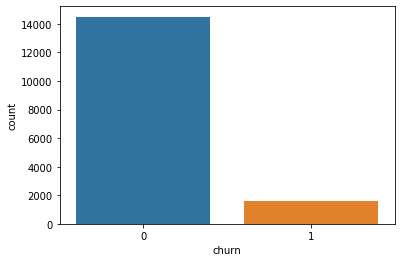

In [29]:
sns.countplot(x = 'churn',data = y)
plt.show()

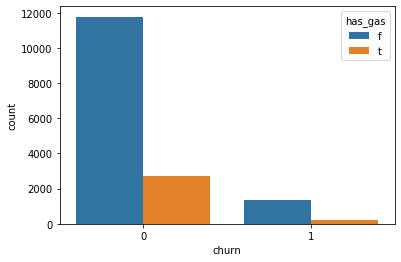

In [30]:
sns.countplot(x = 'churn',data = y,hue = customer_data.has_gas)
plt.show()

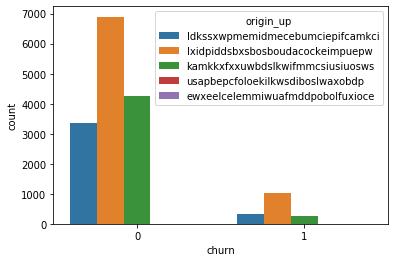

In [31]:
sns.countplot(x = 'churn',data = y,hue = customer_data.origin_up)
plt.show()

In [39]:
label_encoder = LabelEncoder()
for i in cat_features:
    customer_data[i] = label_encoder.fit_transform(customer_data[i].values.reshape(-1,1))

In [42]:
customer_data.shape

(16096, 23)

### Predictive Modelling:

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [47]:
x_train,x_test,y_train,t_test = train_test_split(customer_data,y,test_size = 0.2,random_state = 42)

In [48]:
rfc = RandomForestClassifier()
rfc.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [52]:
accuracy_score(t_test,rfc.predict(x_test))

0.901863354037267

## Our model achieved an accuracy of 90%. With tuning the hyperparameters and using different models, we can further increase this accuracy.

In [55]:
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(x_test)

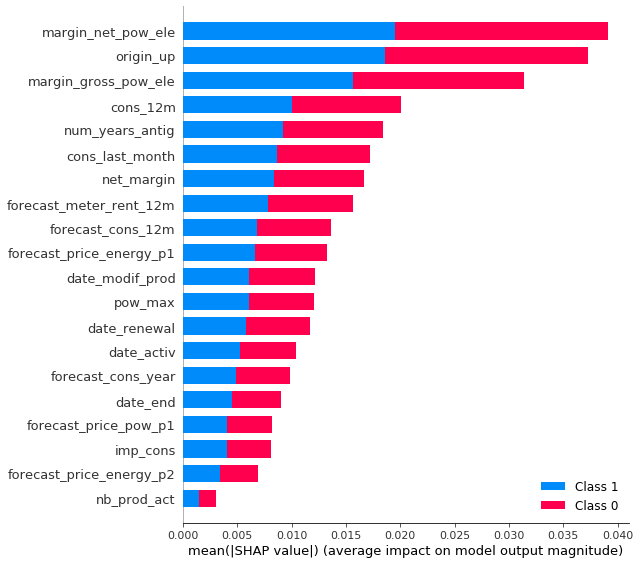

In [56]:
shap.summary_plot(shap_values, x_test, plot_type='bar')